In [2]:
import os

# set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

from numpyro import set_platform

set_platform('gpu')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)

In [4]:
import arviz as az
import pandas as pd
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random, nn, vmap
from functools import partial
import optax

from numpyro.infer import log_likelihood, Predictive

from models import exact_blr, log_ratio, BayesRegression, SVIRegression, BMRRegression
from networks import MLP

rng_key = random.PRNGKey(3742)

In [5]:
# load data
from sklearn.datasets import fetch_openml

optdigits
Iris v=52
UMIST_Faces_Cropped
Comprehensive-database-of-Minerals


mice = fetch_openml(name='miceprotein', version=4, parser="auto")
music = fetch_openml(name='GeographicalOriginalofMusic', parser="auto")
scene = fetch_openml(name='scene', version=1, parser="auto")
wdbc = fetch_openml(name='wdbc', version=1, parser="auto")

SyntaxError: invalid syntax (3599232846.py, line 5)

In [ ]:
def format_and_whiten(rng_key, dataset, p=0.5):
    X = jnp.nan_to_num(dataset.data.astype(float).values)
    X = (X - X.mean(0)) / jnp.clip(X.std(0), a_min=1e-3)

    cov_matrix = jnp.cov(X.T)
    eigen_values, eigen_vectors = jnp.linalg.eigh(cov_matrix)
    keep = eigen_values > 1e-9
    W_pca = eigen_vectors[..., keep] / jnp.sqrt(eigen_values[keep])
    
    X = X @ W_pca
    y = dataset.target
    if y.dtype == 'category':
        name2int = dict([(idx, i) for i, idx in enumerate(y.unique())])
        labels = [name2int[idx] for idx in y.values]
        y = jnp.array(labels)
    else:
        y = jnp.array(y.values)

    n, _ = X.shape
    rng_key, _rng_key = random.split(rng_key)
    train = random.bernoulli(_rng_key, p=p, shape=(n,))

    return X[train], y[train], X[~train], y[~train]

def estimate_loo(smpl, model, y):
    dims = {'obs': ['sample']}

    post_smpl = {}
    for key in smpl:
        if key != 'obs':
            post_smpl[key] = jnp.expand_dims(smpl[key], 0)

    log_lik = log_likelihood(
        model, post_smpl, parallel=True, batch_ndims=2, obs=y
    )

    idata = az.convert_to_inference_data(post_smpl)
    idata.add_groups(log_likelihood=log_lik, dims=dims)
    return az.loo(idata, pointwise=True)

def estimate_elpd(smpl, model, y):
    log_lik = log_likelihood(
        model, smpl, parallel=True, obs=y
    )

    S = log_lik['obs'].shape[0]
    elpd = nn.logsumexp(log_lik['obs'].sum(-1) - jnp.log(S))

    return elpd / len(y)

In [7]:
def compute_loo_nuts(dataset, regtype, seed=0):
    rng_key = random.PRNGKey(seed)
    rng_key, _rng_key = random.split(rng_key)
    X_train, y_train, X_test, y_test = format_and_whiten(_rng_key, dataset)
    _, in_size = X_train.shape

    if regtype == 'multinomial':
        out_size = len(jnp.unique(jnp.array(list(y_train) + list(y_test)))) - 1
    else:
        out_size = 1

    loos = {}
    for depth in [0, 1, 2, 3]:
        loos[depth] = {}
        for width in [10, 20, 30, 40]:
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(in_size, out_size, width, depth, use_bias=True, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            bayesreg = BayesRegression(_rng_key, X_train, nnet, regtype=regtype)

            smpl = bayesreg.fit(
                y_train, 
                num_samples=250, 
                warmup_steps=500, 
                num_chains=4,
                progress_bar=True
            )

            bayesreg.set_input(X_test)
            loos[depth][width] = (estimate_elpd(smpl, bayesreg.model, y_test), smpl)
            print(depth, width, loos[depth][width][0])

            if depth == 0:
                break

    return loos

def compute_loo_svi(dataset, regtype, seed=0):
    rng_key = random.PRNGKey(seed)
    rng_key, _rng_key = random.split(rng_key)
    X_train, y_train, X_test, y_test = format_and_whiten(_rng_key, dataset)
    _, in_size = X_train.shape

    if regtype == 'multinomial':
        out_size = len(jnp.unique(jnp.array(list(y_train) + list(y_test)))) - 1
    else:
        out_size = 1

    rng_key = random.PRNGKey(seed)
    loos = {}
    for depth in [0, 1, 2, 3]:
        loos[depth] = {}
        autoguide = 'multivariate' if depth == 0 else 'mean-field'
        
        for width in [10, 20, 30, 40]:
            print(depth, width)
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(in_size, out_size, width, depth, use_bias=True, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            svireg = SVIRegression(_rng_key, X_train, nnet, regtype=regtype)
        
            smpl = svireg.fit(
                y_train, 
                num_samples=1000, 
                num_steps=50_000,
                autoguide=autoguide,
                progress_bar=False,
                opt_kwargs = {'learning_rate': 1e-3}
            )

            smpl.pop('obs')
            
            svireg.set_input(X_test)
            loos[depth][width] = (estimate_elpd(smpl, svireg.model, y_test), smpl)
            print(depth, width, svireg.results.losses[-1000:].mean(), loos[depth][width][0])

            if depth == 0:
                break

            plt.plot(svireg.results.losses[-1000:])

    return loos

def compute_loo_bmr(dataset, regtype, seed=0):
    rng_key = random.PRNGKey(seed)
    rng_key, _rng_key = random.split(rng_key)
    X_train, y_train, X_test, y_test = format_and_whiten(_rng_key, dataset)
    _, in_size = X_train.shape

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    if regtype == 'multinomial':
        out_size = len(jnp.unique(jnp.array(list(y_train) + list(y_test)))) - 1
    else:
        out_size = 1
    
    loos = {'No-BMR': {regtype: {}}, 'BMR': {regtype: {}}}
    for depth in [0, 1, 2, 3]:
        loos['No-BMR'][regtype][depth] = {}
        loos['BMR'][regtype][depth] = {}

        posterior = 'multivariate' if depth == 0 else 'normal'
        
        for width in [10, 20, 30, 40]:
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(in_size, out_size, width, depth, use_bias=False, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            bmrreg = BMRRegression(
                _rng_key, 
                X_train, 
                nnet, 
                regtype=regtype, 
                posterior=posterior,
                gamma0=1.
            )
        
            bmrreg.fit(
                y_train, 
                num_samples=1000, 
                num_steps=30_000,
                progress_bar=False,
                opt_kwargs = {'learning_rate': 1e-4}
            )
            bmrreg.samples.pop('obs')
            bmrreg.set_input(X_test)
            loos['No-BMR'][regtype][depth][width] = (
                estimate_elpd(bmrreg.samples, bmrreg.model, y_test), 
                bmrreg.samples
            )

            results, smpl = bmrreg.bmr(
                'mean-field', 
                num_steps=20_000, 
                progress_bar=False,
                opt_kwargs={'learning_rate': 1e-4})
            smpl.pop('obs')
            print(
                'F: ', bmrreg.results.losses[-1000:].mean(), 
                '; F + <dF>: ', results.losses[-1000:].mean() + bmrreg.results.losses[-1000:].mean()
            )
            
            loos['BMR'][regtype][depth][width] = (estimate_elpd(smpl, bmrreg.model, y_test), smpl)
            print(depth, width, loos['No-BMR'][regtype][depth][width][0], loos['BMR'][regtype][depth][width][0])

            axes[0].plot(bmrreg.results.losses[-1000:])
            axes[1].plot(results.losses[-1000:])

            if depth == 0:
                break

    return loos


def compute_loo_map(dataset, regtype, seed=0):
    rng_key = random.PRNGKey(seed)
    
    rng_key, _rng_key = random.split(rng_key)
    X_train, y_train, X_test, y_test = format_and_whiten(_rng_key, dataset)
    _, in_size = X_train.shape
    
    if regtype == 'multinomial':
        out_size = len(jnp.unique(jnp.array(list(y_train) + list(y_test)))) - 1
    else:
        out_size = 1

    loos = {}
    for depth in [0, 1, 2, 3]:
        loos[depth] = {}
        
        for width in [10, 20, 30, 40]:
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(in_size, out_size, width, depth, use_bias=True, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            bmrreg = BMRRegression(
                _rng_key, 
                X_train, 
                nnet, 
                regtype=regtype, 
                posterior='delta'
            )
        
            bmrreg.fit(
                y_train, 
                num_samples=1, 
                num_steps=30_000,
                progress_bar=False,
                opt_kwargs = {'learning_rate': 1e-4}
            )

            bmrreg.samples.pop('obs')

            bmrreg.set_input(X_test)

            loos[depth][width] = (estimate_elpd(bmrreg.samples, bmrreg.model, y_test), bmrreg.samples)
            print(depth, width, loos[depth][width][0])

            if depth == 0:
                break

    return loos

try:
    loos_all = jnp.load('real_data_loos.npz', allow_pickle=True)['loos'].item()
except:   
    loos_all = {
        'NUTS': {},
        'SVI': {},
        'No-BMR': {},
        'BMR': {},
        'MAP': {}
    }

### No-U-turn sampler

In [ ]:
for model, data in zip(['linear', 'logistic', 'multinomial'], [music, scene, mice]):
    print(model)
    loos_all['NUTS'][model] = compute_loo_nuts(data, model, 101)
    jnp.savez('real_data_loos.npz', loos=loos_all)

### Stochastic variational inference

In [ ]:
for model, data in zip(['linear', 'logistic', 'multinomial'], [music, wdbc, mice]):
    print(model)
    loos_all['SVI'][model] = compute_loo_svi(data, model, 101)
    jnp.savez('real_data_loos.npz', loos=loos_all)

### Stochastic Bayesian model reduction

In [ ]:
for model, data in zip(['linear'], [music]):
    print(model)
    tmp = compute_loo_bmr(data, model, 101)
    loos_all['No-BMR'][model] = tmp['No-BMR'][model]
    loos_all['BMR'][model] = tmp['BMR'][model]
    jnp.savez('real_data_loos.npz', loos=loos_all)

In [ ]:
for model, data in zip(['logistic'], [wdbc]):
    print(model)
    tmp = compute_loo_bmr(data, model, 101)
    loos_all['No-BMR'][model] = tmp['No-BMR'][model]
    loos_all['BMR'][model] = tmp['BMR'][model]
    jnp.savez('real_data_loos.npz', loos=loos_all)

In [ ]:
for model, data in zip(['multinomial'], [mice]):
    print(model)
    tmp = compute_loo_bmr(data, model, 101)
    loos_all['No-BMR'][model] = tmp['No-BMR'][model]
    loos_all['BMR'][model] = tmp['BMR'][model]
    jnp.savez('real_data_loos.npz', loos=loos_all)

In [ ]:
for model, data in zip(['linear', 'logistic', 'multinomial'], [music, wdbc, mice]):
    print(model)
    loos_all['MAP'][model] = compute_loo_map(data, model, 101)
    jnp.savez('real_data_loos.npz', loos=loos_all)

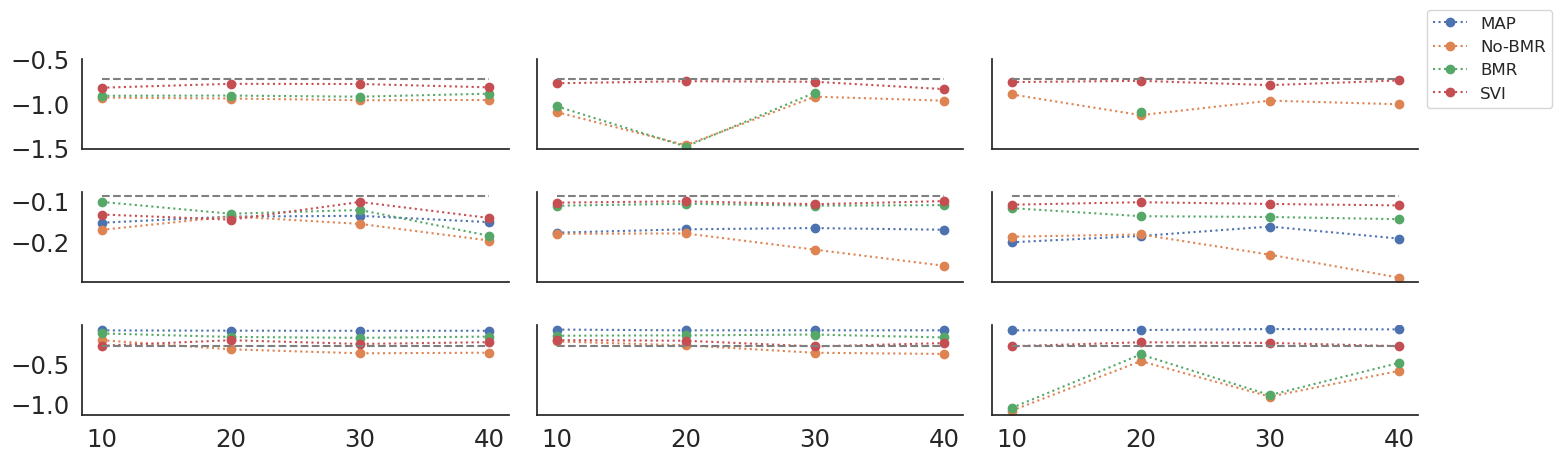

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(16, 5), sharex=True, sharey='row')

widths = [10, 20, 30, 40]
for j, tip in enumerate(['linear', 'logistic', 'multinomial']):
    for d in [1, 2, 3]:
        for method in ['MAP', 'No-BMR', 'BMR', 'SVI']:
            axes[j, d-1].plot(widths, [loos_all[method][tip][d][w][0] for w in widths], 'o:', label=method)
        axes[j, d-1].hlines(loos_all['SVI'][tip][0][10][0], 10, 40, color='gray', linestyle='--')

axes[0, 0].set_ylim([-1.5, -0.5])
# axes[1, 0].set_ylim([-0.15, -0.05])
# axes[2, 0].set_ylim([-0.15, -0.0])


# Put a legend to the right of the current axis
axes[0, -1].legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=12)

# axes[0].set_ylim([-2500, -2200])
fig.tight_layout()
sns.despine()